In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm
import datetime
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score


In [3]:
def load_data(path, rows = 300000):
    """
    Load the training data
    rows --> maximum number of rows to load from the dataset

    """
    data = pd.read_csv(path, header=None, sep=',')
    data = data.drop_duplicates()
    data = data.sample(frac = 1)
    data = data.reset_index(drop=True)
    data = data[:rows]
    data.columns = ['B1', 'C1', 'A2', 'B2', 'C2', 'ma_B1', 'ma_C1', 'ma_A2', 'ma_B2', 'ma_C2']
    
    return data[['B1', 'C1', 'B2']]

def load_data_test(path, rows = 25000):
    """
    Load the testing data (HT clean and HT contaminated)
    rows --> maximum number of rows to load from the dataset
    
    """
    data = pd.read_csv(path, header=None, sep=',')
    data = data.sample(frac = 1)
    data = data.reset_index(drop=True)
    data = data[:rows]
#     data.columns = ['1', '2', '3', '4', '5', 'MA_col1', 'MA_col2', 'MA_col3', 'MA_col4', 'MA_col5']
    data.columns = ['B1', 'C1', 'A2', 'B2', 'C2', 'ma_B1', 'ma_C1', 'ma_A2', 'ma_B2', 'ma_C2']
    # data = data.drop_duplicates()
    return data[['B1', 'C1', 'B2']]

In [4]:
# Define number of rows to load from the dataset
Number_of_train_rows = 10000 
Number_of_test_rows = 25000  # This is only half of the overall test dataframe, since we append HT-clean to HT-contaminated


# Load the dataframes

train_file_path  = r'C:\Users\Gor\Desktop\New_experiments\Important_files-3\new_DATA\Split_into_train_test\HT3_3\4\my_training_data.txt'
test_file_path   = r'C:\Users\Gor\Desktop\New_experiments\Important_files-3\new_DATA\Split_into_train_test\HT3_3\4\my_testing_data.txt'
trojan_file_path = r'C:\Users\Gor\Desktop\New_experiments\Important_files-3\new_DATA\Split_into_train_test\HT3_3\4\my_trojan_data.txt'


# Generate train data
train_data = load_data(train_file_path, rows = Number_of_train_rows)
X_train = np.r_[train_data]
n_train_rows, n_train_columns = X_train.shape

# Generate some regular novel observations
test_data = load_data_test(test_file_path, rows = Number_of_test_rows)
X_test = np.r_[test_data]
n_test_rows, test_columns = X_test.shape

# Generate some abnormal novel observations
trojan_data = load_data_test(trojan_file_path, rows = Number_of_test_rows)
X_outliers = np.r_[trojan_data]
n_outliers_rows, outliers_columns = X_outliers.shape

In [5]:
test_data

,B1,C1,B2
0,12.0,8.8,34.4
1,47.2,51.2,5.6
2,43.2,35.2,8.8
3,47.2,10.4,8.0
4,47.2,8.8,32.8
...,...,...,...
24995,12.8,10.4,8.0
24996,47.2,8.0,8.0
24997,10.4,8.8,6.4
24998,12.0,38.4,8.8


### Quick visualisation of the datapoints

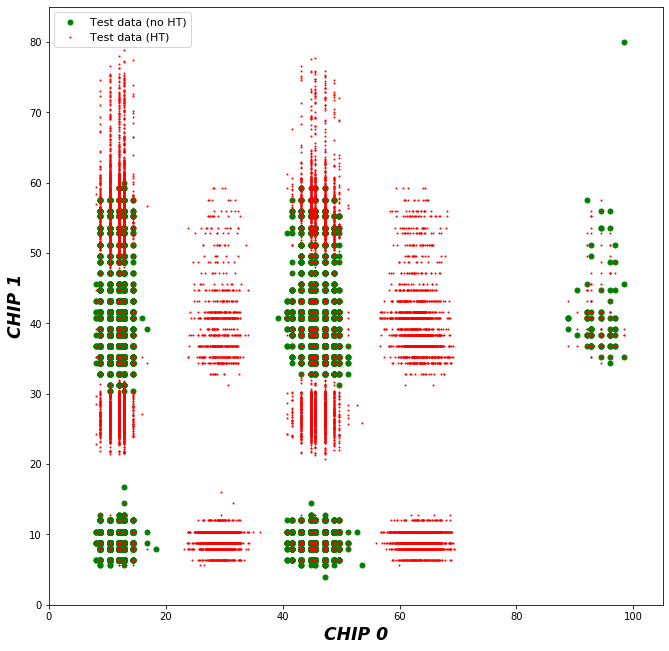

In [6]:
plt.figure(figsize=(11,11))

column1 = 0
column2 = 1

noHT = plt.scatter(X_test[:, column1], X_test[:, column2], c='green', s=25, edgecolors='green')
HT = plt.scatter(X_outliers[:, column1], X_outliers[:, column2], c='red', s=1, edgecolors='red')

plt.axis('tight')
plt.xlim((0, 105))
plt.ylim((0, 85))

plt.legend([noHT, HT], ["Test data (no HT)", "Test data (HT)"], loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))

# plt.xlabel(
#     "Errors train: %d/%d ; "
#     "Errors novel regular: %d/%d ; "
#     "Errors novel abnormal: %d/%d"
#     % (n_error_train, n_train_rows ,n_error_test, n_test_rows, n_error_outliers, n_outliers_rows))
plt.xlabel("CHIP {}".format(column1), fontsize='xx-large', fontstyle='oblique', fontweight='bold')
plt.ylabel("CHIP {}".format(column2), fontsize='xx-large', fontstyle='oblique', fontweight='bold')

plt.show()

#### Prepare the data

In [7]:
y_test = np.ones((Number_of_test_rows,1), dtype='int')
y_outliers = np.negative(np.ones((Number_of_test_rows,1), dtype='int'))
y_test_comined = np.vstack((y_test,y_outliers))
X_test_comined = np.vstack((X_test,X_outliers))
full_test_data = np.hstack((X_test_comined, y_test_comined))
np.random.shuffle(full_test_data)
y_test_comined = full_test_data[:,-1].reshape(int(Number_of_test_rows*2),1)
X_test_comined = full_test_data[:,0:-1]

print("Test data manipulation...")
print(y_test.shape,'  // HT clean test data label shape')
print(y_outliers.shape,'  // HT contaminated test data label shape')
print(y_test_comined.shape,'  // Combined test data label shape')
print()
print(X_test.shape,'  // HT clean test data feature shape')
print(X_outliers.shape,'  // HT contaminated test data feature shape')
print(full_test_data.shape,'  // Combined test data (feature + label) shape')

Test data manipulation...
(25000, 1)   // HT clean test data label shape
(25000, 1)   // HT contaminated test data label shape
(50000, 1)   // Combined test data label shape

(25000, 3)   // HT clean test data feature shape
(25000, 3)   // HT contaminated test data feature shape
(50000, 4)   // Combined test data (feature + label) shape


### Scaling the data..........update: actually worsened the results

In [8]:
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# #Scaling
# # Column_names = X.columns
# scaler = MinMaxScaler()
# scaler.fit(X_train)
# X_train =scaler.transform(X_train)
# X_test_comined = data=scaler.transform(X_test_comined)


# Train the model

In [9]:
# fit the model
nu = 0.0001
gamma = 0.0010
kernel = "rbf"

clf = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
clf.fit(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
y_pred_combined = clf.predict(X_test_comined).reshape(-1,1)

Precision = precision_score(y_test_comined, y_pred_combined)
Recall    = recall_score(y_test_comined, y_pred_combined)
F1_score  = f1_score(y_test_comined, y_pred_combined)
Accuracy  = accuracy_score(y_test_comined, y_pred_combined)
num_of_support_vectors = clf.support_vectors_.shape[0]

In [10]:
print(nu, gamma)
print(F1_score)
print(clf.support_vectors_.shape)

0.0001 0.001
0.7143900239094019
(17, 3)


In [11]:
print(clf.support_vectors_.shape[0])
print(clf.n_support_)

17
[17]


In [12]:
np.savetxt('Support_Vectors.txt', clf.support_vectors_, fmt='%8.2f', delimiter=',')
np.savetxt('Dual_coefs.txt', clf.dual_coef_, fmt='%8.5f', delimiter=',')
np.savetxt('Intercept.txt', clf.intercept_, fmt='%.7f', delimiter=',')